In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

def clean_and_handle_missing_values(df, n_neighbors=3):
    
    df_copy = df.copy()
    process_log = []  # Store list of processes applied
    
    categorical_columns = []
    
    # Step 1: Convert Invalid Numeric Columns to NaN (Preserving Categorical Data)
    for col in df_copy.columns:
        if df_copy[col].dtype == 'O':  # Check if column is object type
            unique_values = df_copy[col].nunique()
            total_values = len(df_copy[col])
            
            # If unique values are significantly less than total, consider categorical
            if unique_values / total_values < 0.5:  
                categorical_columns.append(col)
                process_log.append(f"Preserved categorical column '{col}'.")
                continue  # Skip numeric conversion for categorical columns
            
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')  # Convert valid numbers, set invalid ones as NaN
            process_log.append(f"Converted non-numeric values to NaN in column '{col}'.")
    
    # Step 2: Identify missing value percentage per column
    missing_percentage = df_copy.isnull().sum() / len(df_copy) * 100
    dataset_size = len(df_copy)
    
    # Encode categorical columns before imputation
    label_encoders = {}
    for col in categorical_columns:
        df_copy[col] = df_copy[col].astype(str)  # Ensure all are strings
        label_encoders[col] = LabelEncoder()
        df_copy[col] = label_encoders[col].fit_transform(df_copy[col])
    
    for col in df_copy.columns:
        missing_pct = missing_percentage[col]
        if missing_pct == 0:
            continue  # No missing values

        # Step 3: Drop columns with more than 50% missing values
        if missing_pct > 50:
            df_copy.drop(columns=[col], inplace=True)
            process_log.append(f"Dropped column '{col}' due to >50% missing values.")
            continue

        # Step 4: Handling Numerical Columns
        if np.issubdtype(df_copy[col].dtype, np.number):
            skewness = df_copy[col].skew()
            
            # **Small dataset (<1000 rows)**
            if dataset_size < 1000:
                if missing_pct < 5:
                    df_copy.dropna(subset=[col], inplace=True)
                    process_log.append(f"Dropped rows with missing values in '{col}' (Small dataset).")
                elif abs(skewness) > 1:
                    median_value = df_copy[col].median()
                    df_copy[col].fillna(median_value, inplace=True)
                    process_log.append(f"Filled missing values in '{col}' using median ({median_value}).")
                else:
                    mean_value = df_copy[col].mean()
                    df_copy[col].fillna(mean_value, inplace=True)
                    process_log.append(f"Filled missing values in '{col}' using mean ({mean_value}).")
            
            # **Medium dataset (1000 - 100000 rows)**
            elif dataset_size < 100000:
                iterative_imputer = IterativeImputer()
                df_copy[col] = iterative_imputer.fit_transform(df_copy[[col]])
                process_log.append(f"Applied Iterative Imputation on '{col}' (Medium dataset).")
            
            # **Large dataset (>100000 rows)**
            else:
                if missing_pct < 10:
                    df_copy[col].interpolate(method='linear', inplace=True)
                    process_log.append(f"Used Linear Interpolation for '{col}' (Large dataset).")
                else:
                    df_copy.dropna(subset=[col], inplace=True)
                    process_log.append(f"Dropped rows with missing values in '{col}' (Large dataset).")
    
    # Step 5: Apply KNN Imputation for remaining missing values (if any)
    if df_copy.isnull().sum().sum() > 0:
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        df_copy.iloc[:, :] = knn_imputer.fit_transform(df_copy)
        process_log.append("Applied KNN Imputation for remaining missing values.")
    
    # Decode categorical columns back to original values
    for col in categorical_columns:
        df_copy[col] = label_encoders[col].inverse_transform(df_copy[col].astype(int))
    
    return df_copy, process_log

# Example Dataset with Invalid Entries
df = pd.DataFrame({
    'Age': [25, 30, 'asdfd', 40, 35, 'nsdf', 50],
    'Salary': [50000, 60000, 75000, 'xyz', 85000, 92000, 'pqr'],
    'Gender': ['Male', 'Zczdgd', 'Male', np.nan, 'Female', 'Male', 'Female']
})

print("Original DataFrame:")
print(df)

df_processed, process_steps = clean_and_handle_missing_values(df)

print("\nProcessed DataFrame:")
print(df_processed)

print("\nProcessing Steps:")
for step in process_steps:
    print("-", step)


Original DataFrame:
     Age Salary  Gender
0     25  50000    Male
1     30  60000  Zczdgd
2  asdfd  75000    Male
3     40    xyz     NaN
4     35  85000  Female
5   nsdf  92000    Male
6     50    pqr  Female

Processed DataFrame:
    Age   Salary  Gender
0  25.0  50000.0    Male
1  30.0  60000.0  Zczdgd
2  36.0  75000.0    Male
3  40.0  72400.0     nan
4  35.0  85000.0  Female
5  36.0  92000.0    Male
6  50.0  72400.0  Female

Processing Steps:
- Converted non-numeric values to NaN in column 'Age'.
- Converted non-numeric values to NaN in column 'Salary'.
- Preserved categorical column 'Gender'.
- Filled missing values in 'Age' using mean (36.0).
- Filled missing values in 'Salary' using mean (72400.0).
- Filled missing values in 'Gender' using mean (1.1428571428571428).


In [16]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

def clean_and_handle_missing_values(df, n_neighbors=3, categorical_threshold=0.5):
    """
    Cleans invalid entries and handles missing values optimally based on dataset size.
    """
    df_copy = df.copy()
    process_log = []  # Store list of processes applied
    
    categorical_columns = []
    datetime_columns = []
    
    # Step 1: Identify possible datetime columns based on separators
    for col in df_copy.columns:
        if df_copy[col].dtype == 'O':  # Object type (string-like)
            unique_values = df_copy[col].nunique()
            total_values = len(df_copy[col])
            
            # Detect if it looks like a date (contains '/', '-', or ':')
            if df_copy[col].astype(str).str.contains(r'[/\-:]').any():
                try:
                    df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
                    datetime_columns.append(col)
                    process_log.append(f"Converted '{col}' to datetime format.")
                    continue
                except:
                    pass
            
            # If unique values are significantly less than total, consider categorical
            if unique_values / total_values < categorical_threshold:  
                categorical_columns.append(col)
                process_log.append(f"Preserved categorical column '{col}'.")
                continue  # Skip numeric conversion for categorical columns
            
    # Convert remaining non-categorical values to numeric
    for col in df_copy.columns:
        if col not in categorical_columns and col not in datetime_columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')  # Convert valid numbers, set invalid ones as NaN
            process_log.append(f"Converted non-numeric values to NaN in column '{col}'.")
    
    # Step 2: Identify missing values
    missing_percentage = df_copy.isnull().sum() / len(df_copy) * 100
    dataset_size = len(df_copy)
    
    # Encode categorical columns before imputation
    label_encoders = {}
    for col in categorical_columns:
        if col in df_copy.columns:  # Ensure the column exists
            df_copy[col] = df_copy[col].astype(str)  # Convert to string
            label_encoders[col] = LabelEncoder()
            df_copy[col] = label_encoders[col].fit_transform(df_copy[col].fillna("Unknown"))  # Handle NaN as 'Unknown'
        else:
            process_log.append(f"Warning: '{col}' column is missing after processing.")
    
    # Step 3: Handling Missing Values
    for col in df_copy.columns:
        missing_pct = missing_percentage[col]
        if missing_pct == 0:
            continue  # No missing values

        # Drop columns with >50% missing values
        if missing_pct > 50:
            df_copy.drop(columns=[col], inplace=True)
            process_log.append(f"Dropped column '{col}' due to >50% missing values.")
            continue

        # Handling Numerical and Datetime Columns
        if np.issubdtype(df_copy[col].dtype, np.number):
            skewness = df_copy[col].skew()
            
            # Small dataset (<1000 rows)
            if dataset_size < 1000:
                if missing_pct < 5:
                    df_copy[col].dropna(inplace=True)
                    process_log.append(f"Dropped rows with missing '{col}' (Small dataset).")
                elif abs(skewness) > 1:
                    df_copy[col].fillna(df_copy[col].median(), inplace=True)
                    process_log.append(f"Filled missing '{col}' with median.")
                else:
                    df_copy[col].fillna(df_copy[col].mean(), inplace=True)
                    process_log.append(f"Filled missing '{col}' with mean.")
            
            # Medium dataset (1000 - 100000 rows)
            elif dataset_size < 100000:
                iterative_imputer = IterativeImputer()
                df_copy[col] = iterative_imputer.fit_transform(df_copy[[col]])
                process_log.append(f"Applied Iterative Imputation on '{col}'.")
            
            # Large dataset (>100000 rows)
            else:
                if missing_pct < 10:
                    df_copy[col].interpolate(method='linear', inplace=True)
                    process_log.append(f"Used Linear Interpolation for '{col}'.")
                else:
                    df_copy[col].dropna(inplace=True)
                    process_log.append(f"Dropped rows with missing '{col}' (Large dataset).")
        
        # Handling Datetime Columns
        elif col in datetime_columns:
            df_copy[col] = df_copy[col].fillna(method='ffill')  # Forward fill
            process_log.append(f"Forward-filled missing values in '{col}'.")
    
    # Step 5: Apply KNN Imputation for remaining missing values (if necessary)
    if df_copy.isnull().sum().sum() > 0:
        numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
        
        # Remove columns that are entirely NaN (KNN cannot handle these)
        valid_numeric_cols = [col for col in numeric_cols if df_copy[col].notna().sum() > 0]
        
        if valid_numeric_cols:
            knn_imputer = KNNImputer(n_neighbors=n_neighbors)
            df_copy[valid_numeric_cols] = knn_imputer.fit_transform(df_copy[valid_numeric_cols])
            process_log.append("Applied KNN Imputation for remaining missing values.")
        else:
            process_log.append("Skipped KNN Imputation as no valid numeric columns were found.")

    # Decode categorical columns back
    for col in categorical_columns:
        if col in label_encoders:
            df_copy[col] = label_encoders[col].inverse_transform(df_copy[col].astype(int))
    
    return df_copy, process_log

# Example Dataset
df = pd.DataFrame({
    'Age': [25, 30, 'asdfd', 40, 35, 'nsdf', 50],
    'Salary': [50000, 60000, 75000, 'xyz', 85000, 92000, 'pqr'],
    'Gender': ['Male', 'Female', 'Male', np.nan, 'Female', 'Male', 'Female'],
    'Join_Date': ['2022-01-01', '2022-02-15', 'invalid_date', '2022/04/20', np.nan, '2022-06-30', '2022:07:10']
})

print("Original DataFrame:")
print(df)

df_processed, process_steps = clean_and_handle_missing_values(df)

print("\nProcessed DataFrame:")
print(df_processed)

print("\nProcessing Steps:")
for step in process_steps:
    print("-", step)


Original DataFrame:
     Age Salary  Gender     Join_Date
0     25  50000    Male    2022-01-01
1     30  60000  Female    2022-02-15
2  asdfd  75000    Male  invalid_date
3     40    xyz     NaN    2022/04/20
4     35  85000  Female           NaN
5   nsdf  92000    Male    2022-06-30
6     50    pqr  Female    2022:07:10

Processed DataFrame:
    Age   Salary  Gender
0  25.0  50000.0    Male
1  30.0  60000.0  Female
2  36.0  75000.0    Male
3  40.0  72400.0     nan
4  35.0  85000.0  Female
5  36.0  92000.0    Male
6  50.0  72400.0  Female

Processing Steps:
- Preserved categorical column 'Gender'.
- Converted 'Join_Date' to datetime format.
- Converted non-numeric values to NaN in column 'Age'.
- Converted non-numeric values to NaN in column 'Salary'.
- Filled missing 'Age' with mean.
- Filled missing 'Salary' with mean.
- Filled missing 'Gender' with mean.
- Dropped column 'Join_Date' due to >50% missing values.


In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

def clean_and_handle_missing_values(df, n_neighbors=3, categorical_threshold=0.5):
    """
    Cleans invalid entries and handles missing values optimally based on dataset size.
    """
    df_copy = df.copy()
    process_log = []  # Store list of processes applied
    
    categorical_columns = []
    datetime_columns = []
    
    # Step 1: Convert Invalid Numeric Columns to NaN (Preserving Categorical and Datetime Data)
    for col in df_copy.columns:
        if df_copy[col].dtype == 'O':  # Check if column is object type
            unique_values = df_copy[col].nunique()
            total_values = len(df_copy[col])
            
            # Detect datetime based on common separators
            if df_copy[col].str.contains(r'[-/:]').any():
                try:
                    df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
                    datetime_columns.append(col)
                    process_log.append(f"Converted column '{col}' to datetime format.")
                    continue
                except:
                    pass
            
            # If unique values are significantly less than total, consider categorical
            if unique_values / total_values < categorical_threshold:  
                categorical_columns.append(col)
                process_log.append(f"Preserved categorical column '{col}'.")
                continue  # Skip numeric conversion for categorical columns
            
    # Handle categorical values separately before numeric conversion
    for col in categorical_columns:
        df_copy[col] = df_copy[col].astype(str)  # Ensure all are strings
        process_log.append(f"Categorical column '{col}' handled separately before conversion.")
    
    # Convert remaining non-categorical values to numeric
    for col in df_copy.columns:
        if col not in categorical_columns and col not in datetime_columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')  # Convert valid numbers, set invalid ones as NaN
            process_log.append(f"Converted non-numeric values to NaN in column '{col}'.")
    
    # Step 2: Identify missing value percentage per column
    missing_percentage = df_copy.isnull().sum() / len(df_copy) * 100
    dataset_size = len(df_copy)
    
    # Encode categorical columns before imputation
    label_encoders = {}
    for col in categorical_columns:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].astype(str)  # Ensure all are strings
            label_encoders[col] = LabelEncoder()
            df_copy[col] = label_encoders[col].fit_transform(df_copy[col])
        else:
            print(f"Warning: '{col}' column is missing after processing.")
    
    for col in df_copy.columns:
        missing_pct = missing_percentage[col]
        if missing_pct == 0:
            continue  # No missing values

        # Step 3: Drop columns with more than 50% missing values (except datetime columns)
        if missing_pct > 50 and col not in datetime_columns:
            df_copy.drop(columns=[col], inplace=True)
            process_log.append(f"Dropped column '{col}' due to >50% missing values.")
            continue

        # Step 4: Handling Numerical and Datetime Columns
        if np.issubdtype(df_copy[col].dtype, np.number):
            skewness = df_copy[col].skew()
            
            # **Small dataset (<1000 rows)**
            if dataset_size < 1000:
                if missing_pct < 5:
                    df_copy[col].dropna(inplace=True)
                    process_log.append(f"Dropped rows with missing values in '{col}' (Small dataset).")
                elif abs(skewness) > 1:
                    median_value = df_copy[col].median()
                    df_copy[col].fillna(median_value, inplace=True)
                    process_log.append(f"Filled missing values in '{col}' using median ({median_value}).")
                else:
                    mean_value = df_copy[col].mean()
                    df_copy[col].fillna(mean_value, inplace=True)
                    process_log.append(f"Filled missing values in '{col}' using mean ({mean_value}).")
            
            # **Medium dataset (1000 - 100000 rows)**
            elif dataset_size < 100000:
                iterative_imputer = IterativeImputer()
                df_copy[col] = iterative_imputer.fit_transform(df_copy[[col]])
                process_log.append(f"Applied Iterative Imputation on '{col}' (Medium dataset).")
            
            # **Large dataset (>100000 rows)**
            else:
                if missing_pct < 10:
                    df_copy[col].interpolate(method='linear', inplace=True)
                    process_log.append(f"Used Linear Interpolation for '{col}' (Large dataset).")
                else:
                    df_copy[col].dropna(inplace=True)
                    process_log.append(f"Dropped rows with missing values in '{col}' (Large dataset).")
        
        # Handling Datetime Columns
        elif col in datetime_columns:
            df_copy[col] = df_copy[col].fillna(method='ffill')  # Forward fill for missing timestamps
            process_log.append(f"Applied forward fill for missing values in datetime column '{col}'.")
    
    # Step 5: Apply KNN Imputation for remaining missing values (if necessary)
    if df_copy.isnull().sum().sum() > 0:
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        df_copy.iloc[:, :] = knn_imputer.fit_transform(df_copy)
        process_log.append("Applied KNN Imputation for remaining missing values.")
    
    # Decode categorical columns back to original values
    for col in categorical_columns:
        if col in label_encoders:
            df_copy[col] = label_encoders[col].inverse_transform(df_copy[col].astype(int))
    
    return df_copy, process_log

# Example Dataset with Invalid Entries
df = pd.DataFrame({
    'Age': [25, 30, 'asdfd', 40, 35, 'nsdf', 50],
    'Salary': [50000, 60000, 75000, 'xyz', 85000, 92000, 'pqr'],
    'Gender': ['Male', 'Female', 'Male', np.nan, 'Female', 'Male', 'Female'],
    'Join_Date': ['2022-01-01', '2022-02-15', 'invalid_date', '2022-04-20', np.nan, '2022-06-30', '2022-07-10']
})

print("Original DataFrame:")
print(df)

df_processed, process_steps = clean_and_handle_missing_values(df)

print("\nProcessed DataFrame:")
print(df_processed)

print("\nProcessing Steps:")
for step in process_steps:
    print("-", step)


Original DataFrame:
     Age Salary  Gender     Join_Date
0     25  50000    Male    2022-01-01
1     30  60000  Female    2022-02-15
2  asdfd  75000    Male  invalid_date
3     40    xyz     NaN    2022-04-20
4     35  85000  Female           NaN
5   nsdf  92000    Male    2022-06-30
6     50    pqr  Female    2022-07-10

Processed DataFrame:
    Age   Salary  Gender  Join_Date
0  25.0  50000.0    Male 2022-01-01
1  30.0  60000.0  Female 2022-02-15
2  36.0  75000.0    Male 2022-02-15
3  40.0  72400.0     nan 2022-04-20
4  35.0  85000.0  Female 2022-04-20
5  36.0  92000.0    Male 2022-06-30
6  50.0  72400.0  Female 2022-07-10

Processing Steps:
- Preserved categorical column 'Gender'.
- Converted column 'Join_Date' to datetime format.
- Categorical column 'Gender' handled separately before conversion.
- Converted non-numeric values to NaN in column 'Age'.
- Converted non-numeric values to NaN in column 'Salary'.
- Filled missing values in 'Age' using mean (36.0).
- Filled missing value

C:\Users\akash\AppData\Local\Temp\ipykernel_21820\1391486023.py:111: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy[col] = df_copy[col].fillna(method='ffill')  # Forward fill for missing timestamps



=== Basic Dataset Information ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10 non-null     int64  
 1   Age         9 non-null      float64
 2   Salary      9 non-null      float64
 3   Gender      9 non-null      object 
 4   Experience  9 non-null      float64
 5   Department  10 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 612.0+ bytes
None

First 5 rows:
    ID   Age   Salary  Gender  Experience Department
0   1  25.0  50000.0    Male         2.0         IT
1   2  30.0  60000.0  Female         5.0         HR
2   3   NaN  55000.0    Male         3.0         IT
3   4  40.0      NaN  Female        10.0    Finance
4   5  22.0  52000.0    Male         1.0         HR

=== Checking for Missing Values ===
ID            0
Age           1
Salary        1
Gender        1
Experience    1
Department    0
dt

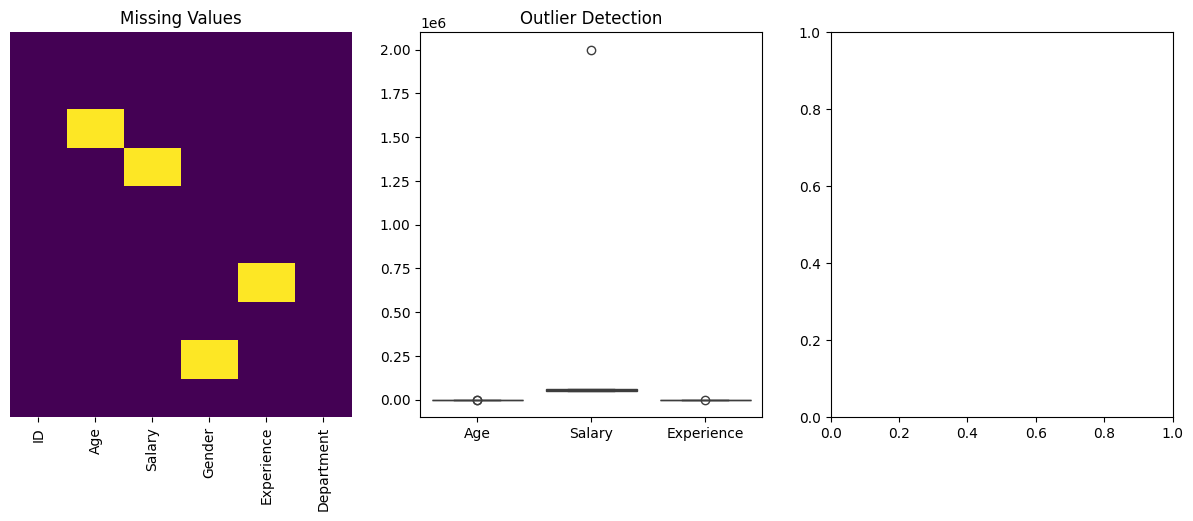

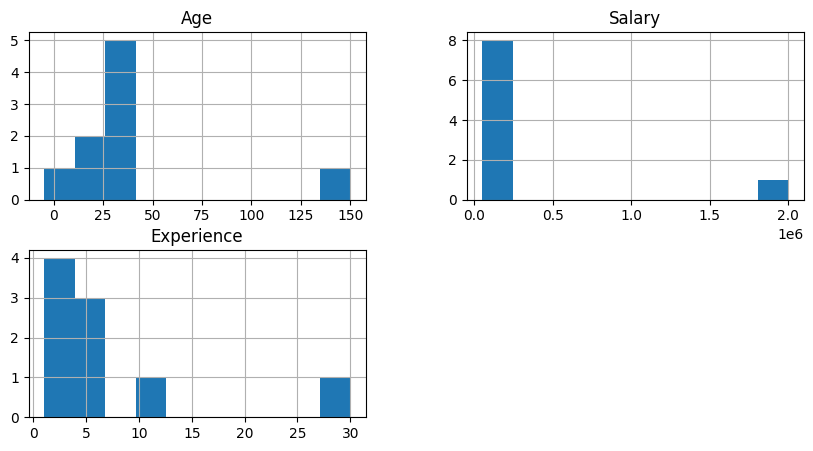

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a sample dataset with errors
data = {
    'ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Age': [25, 30, np.nan, 40, 22, 150, 35, 27, -5, 29],  # Outliers (150, -5) and Missing Value
    'Salary': [50000, 60000, 55000, np.nan, 52000, 2000000, 58000, 49000, 51000, 53000],  # Outlier (2000000)
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Unknown', 'Female', 'Male', np.nan, 'Female'],  # Missing & Invalid Value
    'Experience': [2, 5, 3, 10, 1, 30, np.nan, 4, 6, 3],  # Outlier (30) and Missing Value
    'Department': ['IT', 'HR', 'IT', 'Finance', 'HR', 'Finance', 'IT', 'HR', 'Finance', 'IT'],
}

df = pd.DataFrame(data)

def analyze_dataset(df):
    print("\n=== Basic Dataset Information ===\n")
    print(df.info())
    print("\nFirst 5 rows:\n", df.head())
    
    print("\n=== Checking for Missing Values ===")
    missing_values = df.isnull().sum()
    print(missing_values)
    if missing_values.sum() == 0:
        print("No missing values found.")
    
    print("\n=== Checking for Duplicates ===")
    duplicate_rows = df.duplicated().sum()
    print(f"Duplicate rows: {duplicate_rows}")
    if duplicate_rows == 0:
        print("No duplicate rows found.")
    
    print("\n=== Summary Statistics ===")
    print(df.describe())
    
    print("\n=== Checking for Outliers ===")
    for col in ['Age', 'Salary', 'Experience']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"{col} Outliers:\n", outliers if not outliers.empty else "No outliers found.")
    
    print("\n=== Checking for Incorrect Data Types ===")
    print(df.dtypes)
    
    print("\n=== Visualizing the Data ===")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title("Missing Values")
    
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df[['Age', 'Salary', 'Experience']])
    plt.title("Outlier Detection")
    
    plt.subplot(1, 3, 3)
    df[['Age', 'Salary', 'Experience']].hist(figsize=(10, 5))
    plt.title("Feature Distribution")
    
    plt.show()

# Run analysis
analyze_dataset(df)


In [2]:
import pandas as pd

# Sample DataFrame with all types of data and errors
data = {
    "valid_date": ["2024-02-14", "2023-05-10", "2022-08-21"],  # Valid dates
    "invalid_date": ["2024-13-40", "not_a_date", "21/08/2022"],  # Invalid dates
    "valid_time": ["10:30:00", "15:45:20", "23:59:59"],  # Valid times
    "invalid_time": ["25:61:61", "99:99:99", "hello"],  # Invalid times
    "mixed_date_time": ["2024-02-14 10:30:00", "random_text", "2022/08/21"],  # Mixed values
    "numbers_as_strings": ["123", "45.6", "hello"],  # Mixed numbers & text
    "pure_numbers": [100, 200, 300],  # Pure numeric
    "text_only": ["apple", "banana", "orange"],  # Pure text
}

df = pd.DataFrame(data)

# Print DataFrame
print("Sample Data:")
print(df.info())


Sample Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   valid_date          3 non-null      object
 1   invalid_date        3 non-null      object
 2   valid_time          3 non-null      object
 3   invalid_time        3 non-null      object
 4   mixed_date_time     3 non-null      object
 5   numbers_as_strings  3 non-null      object
 6   pure_numbers        3 non-null      int64 
 7   text_only           3 non-null      object
dtypes: int64(1), object(7)
memory usage: 324.0+ bytes
None


In [3]:
import pandas as pd

# Sample DataFrame with all types of data
data = {
    "valid_date": ["2024-02-14", "2023-05-10", "2022-08-21"],  # Valid dates
    "invalid_date": ["2024-13-40", "not_a_date", "21/08/2022"],  # Invalid dates
    "valid_time": ["10:30:00", "15:45:20", "23:59:59"],  # Valid times
    "invalid_time": ["25:61:61", "99:99:99", "hello"],  # Invalid times
    "mixed_date_time": ["2024-02-14 10:30:00", "random_text", "2022/08/21"],  # Mixed values
    "numbers_as_strings": ["123", "45.6", "hello"],  # Mixed numbers & text
    "pure_numbers": [100, 200, 300],  # Pure numeric
    "text_only": ["apple", "banana", "orange"],  # Pure text
}

df = pd.DataFrame(data)

# Function to classify column types
def classify_columns(df):
    column_types = {}

    for col in df.columns:
        temp_col = df[col].dropna()  # Remove NaN values
        
        # Check if column can be converted to datetime
        if pd.to_datetime(temp_col, errors="coerce").notna().all():
            column_types[col] = "datetime"
        
        # Check if column can be converted to time format
        elif pd.to_datetime(temp_col, format="%H:%M:%S", errors="coerce").notna().all():
            column_types[col] = "time"
        
        # Check if column is numeric
        elif pd.to_numeric(temp_col, errors="coerce").notna().all():
            column_types[col] = "numeric"
        
        else:
            column_types[col] = "string"

    return column_types

# Classify and print results
column_definitions = classify_columns(df)
print("\nColumn Types:")
for col, col_type in column_definitions.items():
    print(f"{col}: {col_type}")



Column Types:
valid_date: datetime
invalid_date: string
valid_time: datetime
invalid_time: string
mixed_date_time: string
numbers_as_strings: string
pure_numbers: datetime
text_only: string


C:\Users\akash\AppData\Local\Temp\ipykernel_9576\1562532406.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(temp_col, errors="coerce").notna().all():
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\1562532406.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(temp_col, errors="coerce").notna().all():
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\1562532406.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(temp_col, errors="coerce").notna().all():
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\1562532406.p

In [5]:
import pandas as pd

def detect_column_issues(df):
    report = []

    for col in df.columns:
        col_data = df[col]
        col_type = "Unknown"
        errors = []

        # 1️⃣ Check for missing values
        missing_count = col_data.isna().sum()
        if missing_count > 0:
            errors.append(f"Missing values: {missing_count}")

        # 2️⃣ Attempt numeric conversion
        numeric_data = pd.to_numeric(col_data, errors='coerce')
        if numeric_data.notna().all():
            col_type = "Numeric"
        elif numeric_data.isna().sum() > 0 and numeric_data.notna().sum() > 0:
            col_type = "Mixed (Numeric & Non-Numeric)"
            errors.append("Contains non-numeric values")

        # 3️⃣ Attempt datetime conversion
        datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
        if datetime_data.notna().all():
            col_type = "Datetime"
        elif datetime_data.isna().sum() > 0 and datetime_data.notna().sum() > 0:
            col_type = "Mixed (Datetime & Non-Datetime)"
            errors.append("Contains invalid dates")

        # 4️⃣ Check for time-only format
        try:
            time_data = pd.to_datetime(col_data, format="%H:%M:%S", errors="coerce")
            if time_data.notna().all():
                col_type = "Time"
        except Exception:
            pass

        # 5️⃣ Categorical / Text Data
        if col_type == "Unknown":
            col_type = "Categorical/Text"

        # Store the findings
        report.append({"Column": col, "Type": col_type, "Issues": ", ".join(errors) if errors else "No issues"})

    return pd.DataFrame(report)

# Sample dataset with all types of data and errors
data =  {
    "valid_date": ["2024-02-14", "2023-05-10", "2022-08-21"],  # Valid dates
    "invalid_date": ["2024-13-40", "not_a_date", "21/08/2022"],  # Invalid dates
    "valid_time": ["10:30:00", "15:45:20", "23:59:59"],  # Valid times
    "invalid_time": ["25:61:61", "99:99:99", "hello"],  # Invalid times
    "mixed_date_time": ["2024-02-14 10:30:00", "random_text", "2022/08/21"],  # Mixed values
    "numbers_as_strings": ["123", "45.6", "hello"],  # Mixed numbers & text
    "pure_numbers": [100, 200, 300],  # Pure numeric
    "text_only": ["apple", "banana", "orange"],  # Pure text
}

df = pd.DataFrame(data)

# Run the error detection
error_report = detect_column_issues(df)

# Print the report
print(error_report)



               Column                             Type  \
0          valid_date                         Datetime   
1        invalid_date  Mixed (Datetime & Non-Datetime)   
2          valid_time                             Time   
3        invalid_time                 Categorical/Text   
4     mixed_date_time  Mixed (Datetime & Non-Datetime)   
5  numbers_as_strings    Mixed (Numeric & Non-Numeric)   
6        pure_numbers                         Datetime   
7           text_only                 Categorical/Text   

                        Issues  
0                    No issues  
1       Contains invalid dates  
2                    No issues  
3                    No issues  
4       Contains invalid dates  
5  Contains non-numeric values  
6                    No issues  
7                    No issues  


C:\Users\akash\AppData\Local\Temp\ipykernel_9576\606168416.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\606168416.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\606168416.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\606168416.py:

In [ ]:
import pandas as pd
import re









def detect_column_issues(df):
    report = []

    for col in df.columns:
        col_data = df[col]
        col_type = "Unknown"
        errors = []

        # 1️⃣ Check for missing values
        missing_count = col_data.isna().sum()
        if missing_count > 0:
            errors.append(f"Missing values: {missing_count}")

        # 2️⃣ Attempt numeric conversion
        numeric_data = pd.to_numeric(col_data, errors='coerce')
        if numeric_data.notna().all():
            col_type = "Numeric"
        elif numeric_data.isna().sum() > 0 and numeric_data.notna().sum() > 0:
            col_type = "Mixed (Numeric & Non-Numeric)"
            errors.append("Contains non-numeric values")

        # 3️⃣ Attempt datetime conversion (only if not already Numeric)
        if col_type == "Unknown":
            datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
            if datetime_data.notna().all():
                col_type = "Datetime"
            elif datetime_data.isna().sum() > 0 and datetime_data.notna().sum() > 0:
                col_type = "Mixed (Datetime & Non-Datetime)"
                errors.append("Contains invalid dates")

        # 4️⃣ Strict Time Validation (Only if all values look like time)
        time_pattern = re.compile(r"^(?:[01]\d|2[0-3]):[0-5]\d:[0-5]\d$")
        if col_data.astype(str).apply(lambda x: bool(time_pattern.match(str(x)))).all():
            col_type = "Time"
        elif col_data.astype(str).apply(lambda x: bool(time_pattern.match(str(x)))).sum() > 0:
            col_type = "Mixed (Valid & Invalid Time)"
            invalid_times = col_data.astype(str).apply(lambda x: not bool(time_pattern.match(str(x))) if isinstance(x, str) else False).sum()
            if invalid_times > 0:
                errors.append(f"Contains {invalid_times} invalid time values")

        # 5️⃣ Categorical / Text Data
        if col_type == "Unknown":
            col_type = "Categorical/Text"

        # Store the findings
        report.append({"Column": col, "Type": col_type, "Issues": ", ".join(errors) if errors else "No issues"})

    return pd.DataFrame(report)

# Sample dataset with all types of data and errors
data = {
    "valid_date": ["2024-02-14", "2023-05-10", "2022-08-21"],  # Valid dates
    "invalid_date": ["2024-13-40", "not_a_date", "21/08/2022"],  # Invalid dates
    "valid_time": ["10:30:00", "15:45:20", "23:59:59"],  # Valid times
    "invalid_time": ["25:61:61", "99:99:99", "hello"],  # Invalid times
    "mixed_date_time": ["2024-02-14 10:30:00", "random_text", "2022/08/21"],  # Mixed values
    "numbers_as_strings": ["123", "45.6", "hello"],  # Mixed numbers & text
    "pure_numbers": [100, 200, 300],  # Pure numeric
    "text_only": ["apple", "banana", "orange"],  # Pure text
}

df = pd.DataFrame(data)

# Run the error detection
error_report = detect_column_issues(df)

# Print the report
print(error_report)


               Column                             Type  \
0          valid_date                         Datetime   
1        invalid_date  Mixed (Datetime & Non-Datetime)   
2          valid_time                             Time   
3        invalid_time                 Categorical/Text   
4     mixed_date_time  Mixed (Datetime & Non-Datetime)   
5  numbers_as_strings    Mixed (Numeric & Non-Numeric)   
6        pure_numbers                          Numeric   
7           text_only                 Categorical/Text   

                        Issues  
0                    No issues  
1       Contains invalid dates  
2                    No issues  
3                    No issues  
4       Contains invalid dates  
5  Contains non-numeric values  
6                    No issues  
7                    No issues  


C:\Users\akash\AppData\Local\Temp\ipykernel_9576\4195982490.py:27: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\4195982490.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\4195982490.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
C:\Users\akash\AppData\Local\Temp\ipykernel_9576\4195982490

In [7]:
import pandas as pd

df = pd.DataFrame({
    "valid_date": ["2024-02-14", "2023-05-10", "2022-08-21"],
    "invalid_date": ["2024-13-40", "not_a_date", "21/08/2022"],
    "valid_time": ["10:30:00", "15:45:20", "23:59:59"],
    "invalid_time": ["25:61:61", "99:99:99", "hello"],
    "mixed_date_time": ["2024-02-14 10:30:00", "random_text", "2022/08/21"],
    "numbers_as_strings": ["123", "45.6", "hello"],
    "pure_numbers": ["100", "200", "300"],
    "text_only": ["apple", "banana", "orange"]
})

json_data = df.to_dict(orient="records")  # Convert to JSON format
print(json_data)


[{'valid_date': '2024-02-14', 'invalid_date': '2024-13-40', 'valid_time': '10:30:00', 'invalid_time': '25:61:61', 'mixed_date_time': '2024-02-14 10:30:00', 'numbers_as_strings': '123', 'pure_numbers': '100', 'text_only': 'apple'}, {'valid_date': '2023-05-10', 'invalid_date': 'not_a_date', 'valid_time': '15:45:20', 'invalid_time': '99:99:99', 'mixed_date_time': 'random_text', 'numbers_as_strings': '45.6', 'pure_numbers': '200', 'text_only': 'banana'}, {'valid_date': '2022-08-21', 'invalid_date': '21/08/2022', 'valid_time': '23:59:59', 'invalid_time': 'hello', 'mixed_date_time': '2022/08/21', 'numbers_as_strings': 'hello', 'pure_numbers': '300', 'text_only': 'orange'}]


In [11]:
def detect_column_issues(df):
    report = []

    for col in df.columns:
        col_data = df[col]
        col_type = "Unknown"
        errors = []

        #  Check for missing values
        missing_count = col_data.isna().sum()
        if missing_count > 0:
            errors.append(f"Missing values: {missing_count}")

        #  Attempt numeric conversion
        numeric_data = pd.to_numeric(col_data, errors='coerce')
        if numeric_data.notna().all():
            col_type = "Numeric"
        elif numeric_data.isna().sum() > 0 and numeric_data.notna().sum() > 0:
            col_type = "Mixed (Numeric & Non-Numeric)"
            errors.append("Contains non-numeric values")

        # Attempt datetime conversion (only if not already Numeric)
        if col_type == "Unknown":
            datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)
            if datetime_data.notna().all():
                col_type = "Datetime"
            elif datetime_data.isna().sum() > 0 and datetime_data.notna().sum() > 0:
                col_type = "Mixed (Datetime & Non-Datetime)"
                errors.append("Contains invalid dates")

        #  Strict Time Validation (Only if all values look like time)
        time_pattern = re.compile(r"^(?:[01]\d|2[0-3]):[0-5]\d:[0-5]\d$")
        if col_data.astype(str).apply(lambda x: bool(time_pattern.match(str(x)))).all():
            col_type = "Time"
        elif col_data.astype(str).apply(lambda x: bool(time_pattern.match(str(x)))).sum() > 0:
            col_type = "Mixed (Valid & Invalid Time)"
            invalid_times = col_data.astype(str).apply(lambda x: not bool(time_pattern.match(str(x))) if isinstance(x, str) else False).sum()
            if invalid_times > 0:
                errors.append(f"Contains {invalid_times} invalid time values")

        # 5️⃣ Categorical / Text Data
        if col_type == "Unknown":
            col_type = "Categorical/Text"

        # Store the findings
        report.append({"Column": col, "Type": col_type, "Issues": ", ".join(errors) if errors else "No issues"})

    return pd.DataFrame(report)


# Sample dataset with all types of data and errors
df =df = pd.read_csv("Toyota.csv")


# Run the error detection
error_report = detect_column_issues(df)

# Print the report
print(error_report)



      Column                           Type  \
0      Price                        Numeric   
1        Age  Mixed (Numeric & Non-Numeric)   
2         KM  Mixed (Numeric & Non-Numeric)   
3   FuelType               Categorical/Text   
4         HP  Mixed (Numeric & Non-Numeric)   
5   MetColor  Mixed (Numeric & Non-Numeric)   
6  Automatic                        Numeric   
7         CC                        Numeric   
8      Doors  Mixed (Numeric & Non-Numeric)   
9     Weight                        Numeric   

                                             Issues  
0                                         No issues  
1  Missing values: 100, Contains non-numeric values  
2                       Contains non-numeric values  
3                               Missing values: 100  
4                       Contains non-numeric values  
5  Missing values: 150, Contains non-numeric values  
6                                         No issues  
7                                         No issue

C:\Users\akash\AppData\Local\Temp\ipykernel_30088\3425579120.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_data = pd.to_datetime(col_data, errors='coerce', dayfirst=True)


In [8]:
import pandas as pd
data=pd.read_csv("timeco.csv")
print(data.describe())

            Revenue  Sales_quantity  Average_cost  \
count  6.400000e+01       64.000000     64.000000   
mean   3.236045e+07    19197.375000   1695.061159   
std    1.164150e+07     6591.287257    296.844793   
min    1.402148e+07     8314.000000   1110.576805   
25%    2.242655e+07    15065.500000   1499.142841   
50%    3.209088e+07    18368.000000   1654.399797   
75%    3.992999e+07    22856.250000   1916.401095   
max    5.875647e+07    38069.000000   2559.328184   

       The_average_annual_payroll_of_the_region  
count                              6.400000e+01  
mean                               2.869083e+07  
std                                1.057191e+06  
min                                2.740647e+07  
25%                                2.782857e+07  
50%                                2.819785e+07  
75%                                2.987852e+07  
max                                3.002468e+07  
